<a href="https://colab.research.google.com/github/dasdebojit/Masked-Face-detection/blob/master/Accurate_mask_pytorch_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing torch based modules
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt 
import torch
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

In [ ]:
# Importing Non-PyTorch Modules
import pandas as pd
import numpy as np
import cv2
import os
import PIL
import time
from imageio import imread
import matplotlib.pyplot as plt
import random
import sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pathlib import Path
path = Path('/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1')
save_path = Path('/content/drive/My Drive/Colab Notebooks/DL_datasets/face_images')

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 41kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=ed2b68795cff9743b28a507fc6ef8e3d0855b868bb8e916489666255ec152c61
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import face_recognition

## P.S.: Please don't run this cell while testing

In [ ]:
# While testing, please don't run this cell since this was only used to create the dataset of cropped images
# this fragment of code is traversing through the RWMFD datset and making well cropped images and saving it to a new directory on google drive
# this is the one which saves the cropped images in face images folder (i.e. save_path)

images = []
format = '.jpeg'
j = 0
for root, _, files in os.walk(path):
  for file_ in files:
    if( root[65] == 'N'):
      masked = 0
    else:
      masked = 1
    
    image_name = os.path.join(root, file_)
    cv_img = cv2.imread(image_name)
    cv_img_colored = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    face_location = face_recognition.face_locations(cv_img_colored)
    for face in face_location:
      top, right, bottom, left = face
      x, y, w, h = left, top, right, bottom
      cropped_img = cv_img[y:h, x:w]
      cv2.imwrite(os.path.join(save_path, f"face{j}.jpg"), cropped_img)
      images.append([f"face{j}.jpg", masked])
      j = j+1



The following couple of cells are to be run in lieu of the above cells to create a dataframe which would be used to retrieve image names along with their corresponding image tags i.e. (Masked/Unmasked) 

In [ ]:
   images = []
for i in range(364):
  images.append([f"face{i}.jpg", 1])
for i in range(364, 364*2):
  images.append([f"face{i}.jpg", 0])

In [ ]:
images = images[:364*2]
len(images)

728

In [ ]:
df = pd.DataFrame(data = images, columns = ['image_names', 'masked'])
df.head()

,image_names,masked
0,face0.jpg,1
1,face1.jpg,1
2,face2.jpg,1
3,face3.jpg,1
4,face4.jpg,1


## Defining the Dataset class

In [ ]:
class Dataset(Dataset):
  def __init__(self, dataset, transform = None):
    self.df = dataset
    self.transform = transform
    self.len = len(dataset)

  def __len__(self):
    return self.len
  
  def __getitem__(self, idx):
    img_name = os.path.join(save_path, str(self.df.iloc[idx, 0]))
    image = Image.open(img_name)
    y = self.df.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    return image, y

## Sample Masked Images from the dataset

[]

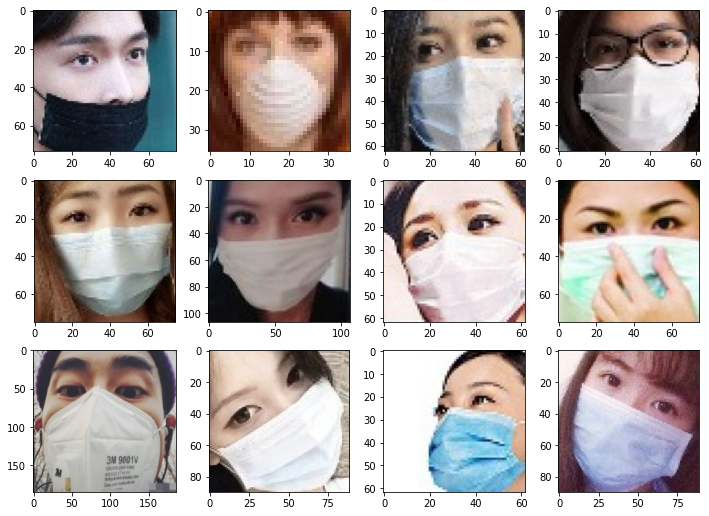

In [ ]:
i = 1
fig = plt.figure(figsize=(12, 12))
for image in df['image_names']:
  img = Image.open(os.path.join(save_path, image))
  ax = fig.add_subplot(4, 4, i)
  plt.imshow(img)
  i += 1
  if(i == 13):
    break
plt.plot()

## Sample Unmasked Images from the dataset

[]

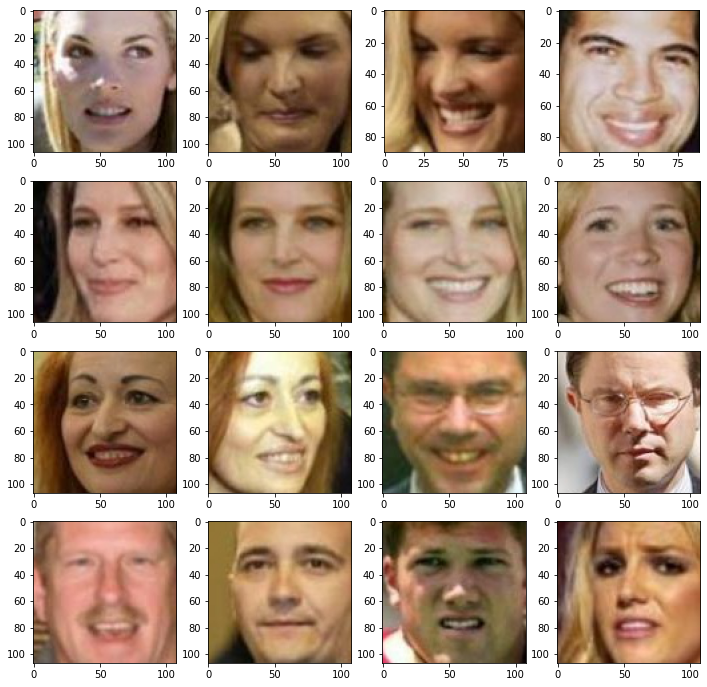

In [ ]:
i = 1
fig = plt.figure(figsize=(12, 12))
for j, image in enumerate(df['image_names']):
  if(j<=364):
    continue
  img = Image.open(os.path.join(save_path, image))
  ax = fig.add_subplot(4, 4, i)
  plt.imshow(img)
  i += 1
  if(i == 17):
    break
plt.plot()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, shuffle = True)
train, val = train_test_split(train, test_size = 0.2, shuffle = True)

## The training, validation and test sets have a balanced distribution of both types of targets

In [ ]:
print(train['masked'].value_counts())
print(val['masked'].value_counts())
print(test['masked'].value_counts())

1    236
0    229
Name: masked, dtype: int64
0    63
1    54
Name: masked, dtype: int64
1    75
0    71
Name: masked, dtype: int64


## Loading datasets in dataloaders via necessary transformations 

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.229, 0.224, 0.225] 
composed = transforms.Compose([transforms.Resize((224, 224)), 
                               transforms.RandomHorizontalFlip(), 
                               #transforms.RandomRotation(30),
                               transforms.ToTensor(), 
                               transforms.Normalize(mean, std)])

In [ ]:
train_dataset = Dataset(dataset = train, transform = composed)
val_dataset = Dataset(dataset = val, transform = composed)
test_dataset = Dataset(dataset = test, transform = composed)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 20)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = 20)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset)

## Using RESNET-18 with pretrained weights

In [ ]:
#obtaining model resnet18
model = models.resnet18(pretrained = True)
for params in model.parameters():
  params.requires_grad = False

In [ ]:
model.fc = nn.Linear(512, 2)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam([params for params in model.parameters() if params.requires_grad == True], lr = 1e-4)

In [ ]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


## Training the model 

In [ ]:
epochs = 10
loss_list= []
acc_list = []
n_val = len(val_dataset)

for epoch in range(epochs):
  correct = 0
  loss_sublist = []
  for x_train, y_train in train_loader:
    model.train()
    z = model(x_train)
    loss = criterion(z, y_train)
    loss_sublist.append(loss.data.item())
    loss.backward()
    optim.step()
    print('/', end='')
  loss_list.append(np.mean(loss_sublist))  

  for x_val, y_val in val_loader:
    model.eval()
    z = model(x_val)
    _, yhat = torch.max(z, 1)
    correct += (yhat == y_val).sum().item()
    print('/', end = '')
  
  avg_correct = correct/n_val
  acc_list.append(avg_correct)
  print(f"Epoch[{epoch+1} / {epochs}]")
  print("-"*100)
  print(f"Training loss: {np.mean(loss_sublist)}")
  print(f"Vadliation Accuracy: {avg_correct}")
  print("-"*100)
  print("-"*100)

//////////////////////////////Epoch[1 / 10]
----------------------------------------------------------------------------------------------------
Training loss: 0.6116252367695173
Vadliation Accuracy: 0.7094017094017094
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
//////////////////////////////Epoch[2 / 10]
----------------------------------------------------------------------------------------------------
Training loss: 0.47598043580849964
Vadliation Accuracy: 0.8632478632478633
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
//////////////////////////////Epoch[3 / 10]
----------------------------------------------------------------------------------------------------
Training los

## Training loss and Validation Accuracy

Text(0, 0.5, 'Loss on Training Set')

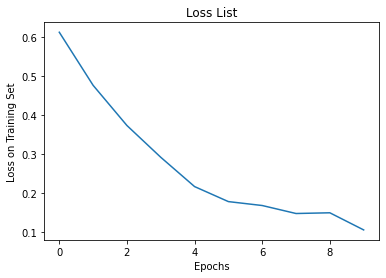

In [ ]:
plt.plot(loss_list)
plt.title('Loss List')
plt.xlabel('Epochs')
plt.ylabel('Loss on Training Set')

Text(0, 0.5, 'Accuracy on Validation Set')

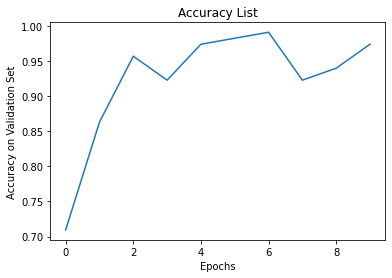

In [ ]:
plt.plot(acc_list)
plt.title('Accuracy List')
plt.xlabel('Epochs')
plt.ylabel('Accuracy on Validation Set')

### Saving the model in google drive 

In [ ]:
#saving the model on my google drive
# while testing please dont run this
# however you may run it in case your accuracy is better than that already achieved

model_save_name = 'mask_model3.pt'
path = F"/content/drive/My Drive/Colab Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)

Testing the model on test-set

In [ ]:
# predicting results from unsaved model

correct = 0
result = []
for x_test, y_test in test_loader:
  model.eval()
  z = model(x_test)
  _, yhat = torch.max(z, 1)
  result.append(yhat)
  correct += (yhat == y_test).sum().item()
print('Accuracy: ', correct/len(test_dataset))

## Testing the model on test-set by loading model.pt from google drive

In [ ]:
# For testing the testset on the trained model, use the following code cell to load trained model for prediction

load_model = models.resnet18(pretrained = True)
load_model.fc = nn.Linear(512, 2)
model_save_name = 'mask_model2.pt'
path = F"/content/drive/My Drive/Colab Notebooks/{model_save_name}"
load_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# predicting results from saved model

correct = 0
result = []
for x_test, y_test in test_loader:
  load_model.eval()
  z = load_model(x_test)
  _, yhat = torch.max(z, 1)
  result.append(yhat)
  correct += (yhat == y_test).sum().item()
print('Accuracy: ', correct/len(test_dataset))

Accuracy:  0.9794520547945206


## Visualizing the Results

In [ ]:
inv_mean = []
inv_std = []
for i in range(len(mean)):
  inv_mean.append(-mean[i]/std[i])
  inv_std.append(1/std[i])

inv_transform = transforms.Normalize(inv_mean, inv_std)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[]

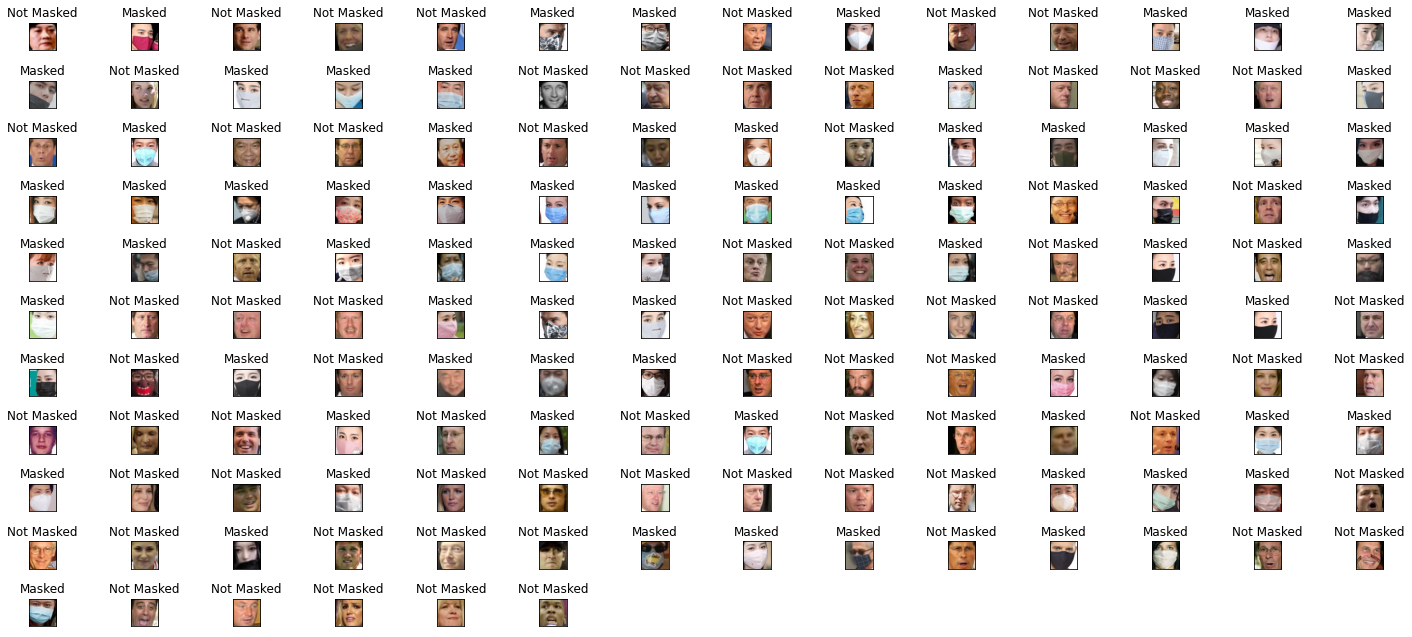

In [ ]:
# from IPython.display import display
masked = {1: 'Masked', 0: 'Not Masked'}

j = 1
fig = plt.figure(figsize = (20, 800))

for i, (x_test, y_test) in enumerate(test_loader):
  x_test = x_test.resize(3, 224, 224)
  x_test = inv_transform(x_test)
  toImage = transforms.ToPILImage()
  x_img = toImage(x_test)
  ax = fig.add_subplot(1000, 14, j)
  ax.set_title(masked[result[i].data.item()])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_img)
  j += 1
  # display(x_img)
fig.tight_layout()
plt.plot()